In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import sklearn
from sklearn.preprocessing import MinMaxScaler as sc
import talib

import math
import os
import datetime

import warnings; warnings.simplefilter('ignore')

In [4]:
cols = ['date_time', 'open', 'high', 'low', 'close', 'volume']
patt1 = '/Users/justinsimcock/data/securities_data/etx/' 
patt2 = 'DAT_ASCII_ETXEUR_M1_{year}.csv'
dfs = []
for y in range(2010,2019):
     dfs.append(pd.read_csv(patt1 + patt2.format(year=y), sep=';', header=-1, names = cols))

#concat dfs into one
etx = pd.concat(dfs, axis=0)

In [5]:
etx.isnull().any()

date_time    False
open         False
high         False
low          False
close        False
volume       False
dtype: bool

### Let's have a look at the data

In [6]:
etx.head()

,date_time,open,high,low,close,volume
0,20101115 020000,2805.0,2805.0,2803.0,2805.0,0
1,20101115 020100,2806.0,2807.0,2806.0,2807.0,0
2,20101115 020200,2808.0,2808.0,2808.0,2808.0,0
3,20101115 020300,2807.0,2808.0,2807.0,2808.0,0
4,20101115 020400,2809.0,2809.0,2809.0,2809.0,0


In [7]:
etx['date_time'] =  etx['date_time'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d %H%M%S'))
etx = etx.set_index('date_time')

In [11]:
etx_daily = etx.close.resample('1D').ohlc()
etx_daily = etx_daily.dropna()

In [12]:
etx_daily.head()

,open,high,low,close
date_time,,,,
2010-11-15,2805.0,2856.0,2796.0,2838.0
2010-11-16,2818.0,2828.0,2770.0,2783.0
2010-11-17,2783.0,2806.0,2772.0,2798.0
2010-11-18,2835.0,2858.0,2823.0,2854.0
2010-11-19,2856.0,2862.0,2819.0,2856.0


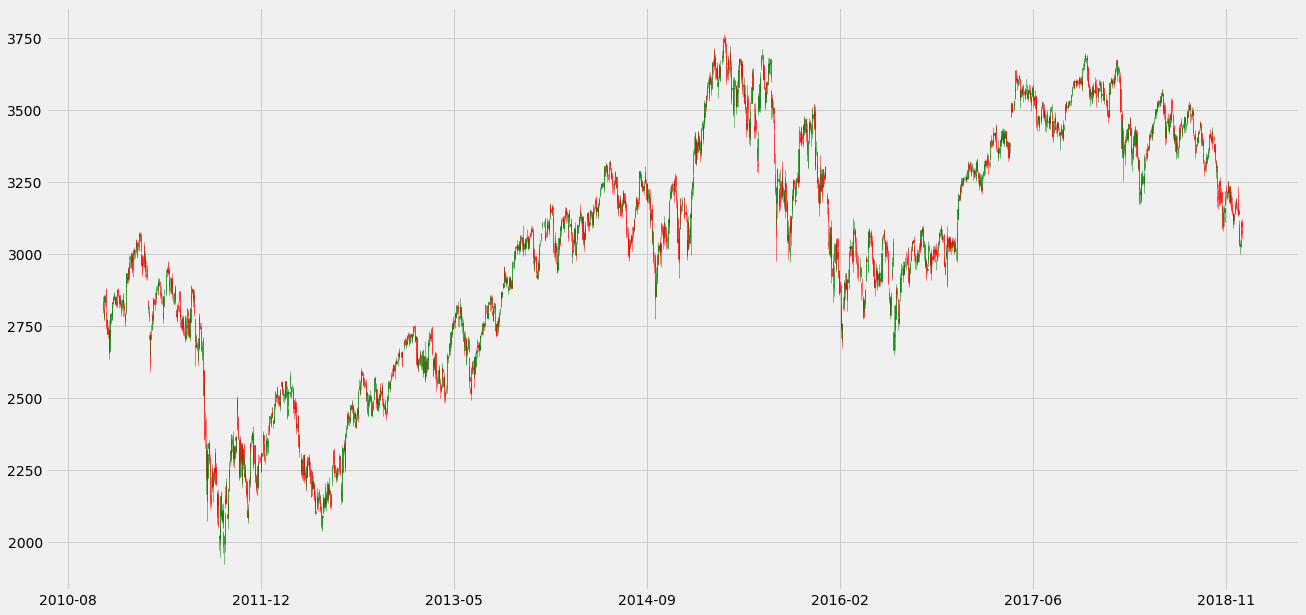

In [19]:
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

import plotly.plotly as py
import plotly.graph_objs as go
from matplotlib import style
style.use('fivethirtyeight')

f1, ax = plt.subplots(figsize = (20,10))

etx_daily = etx_daily.loc[etx_daily['close'] < 4000]

etx_daily['date_time'] = mdates.date2num(etx_daily.index.to_pydatetime())

ohlc = etx_daily[['date_time', 'open', 'high', 'low','close']].copy()

candlestick_ohlc(ax, ohlc.values, width=.6, colorup='green', colordown='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

etx_daily = etx_daily.drop(columns='date_time')

In [23]:
etx_4H = etx.close.resample('4H').ohlc()
etx_4H = etx_4H.dropna()
len(etx_4H)

8545

In [42]:
#etx_4H = etx_4h.loc[etx_4H['open'] < 4000]


In [43]:
etx_4H.tail()

,open,high,low,close
date_time,,,,
2018-12-13 12:00:00,3102.0,3107.0,3097.0,3099.0
2018-12-14 00:00:00,3085.0,3088.0,3060.0,3060.0
2018-12-14 04:00:00,3062.0,3087.0,3057.0,3082.0
2018-12-14 08:00:00,3082.0,3097.0,3078.0,3078.0
2018-12-14 12:00:00,3080.0,3087.0,3072.0,3072.0


In [44]:
df = etx_4H
df['h-l'] = df['high'] - df['low']
df['o-c'] = df['open'] - df['close']
df['3p_ma'] = df.close.shift(1).rolling(window=3).mean()
df['10p_ma'] = df.close.shift(1).rolling(window=10).mean()
df['30p_ma'] = df.close.shift(1).rolling(window=30).mean()
df['5p_std'] = df.close.rolling(window=5).std()


#define out target variable
df['return'] = np.where(df.close.shift(-1) > df.close, 1, 0)
df = df.dropna()

#We only want the columns with features. We will remove the open, high, low, close, columns
feature_matrix = df.iloc[:,4:]

In [45]:
feature_matrix.head()


,h-l,o-c,3p_ma,10p_ma,30p_ma,5p_std,return
date_time,,,,,,,
2010-11-23 08:00:00,34.0,15.0,2790.666667,2822.5,2821.200000,32.611348,0
2010-11-23 12:00:00,14.0,1.0,2766.666667,2814.2,2819.366667,31.942135,0
2010-11-24 00:00:00,34.0,32.0,2750.666667,2804.1,2816.366667,26.159128,1
2010-11-24 04:00:00,34.0,-23.0,2737.666667,2790.7,2811.966667,14.081903,1
2010-11-24 08:00:00,19.0,-8.0,2738.333333,2778.8,2808.966667,12.973049,1


In [46]:
n = feature_matrix.shape[0]
p = feature_matrix.shape[1]

data = feature_matrix.values


train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n
data_train = data[np.arange(train_start, train_end),:]
data_test = data[np.arange(test_start, test_end), :]

In [47]:
scaler = sc(feature_range=(-1,1))
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)


X_train = data_train[:, 0:-1]
y_train = data_train[:,-1]

X_test = data_test[:, 0:-1]
y_test = data_test[:, -1]
data_test.shape

(1696, 7)

In [48]:
net = tf.InteractiveSession()

In [49]:
n_features = X_train.shape[1]

# num neurons for each layer
# these number of neurons are arbitrary

n_neurons_1 = 512
n_neurons_2 = 256
n_neurons_3 = 128

In [50]:
X = tf.placeholder(dtype=tf.float32, shape=[None, n_features])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode='fan_avg', distribution='uniform', scale=sigma)
bias_initializer = tf.zeros_initializer()

In [51]:
weights_hidden_1 = tf.Variable(weight_initializer([n_features, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))

weights_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

weights_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))

#Output layers

W_output = tf.Variable(weight_initializer([n_neurons_3, 1]))
bias_output = tf.Variable(bias_initializer([1]))


In [52]:
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, weights_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, weights_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, weights_hidden_3), bias_hidden_3))

#network output
output_layer = tf.transpose(tf.add(tf.matmul(hidden_3, W_output), bias_output))
                            
                            
#cost function used to measure deviation from predicted and actual
mse = tf.reduce_mean(tf.squared_difference(output_layer, Y))


#optimizer is necessary during the adjustment of the weights and bias variables during training
#computes gradients that indicate direction of weights and biases need to be changed to minimize cost function
#Adaptive Moment Estimation: ADAM Optimizer is a type of stochastic gradient descent
opt = tf.train.AdamOptimizer().minimize(mse)

net.run(tf.global_variables_initializer())

In [53]:
batch_size = 32
epochs = 50
for e in range(epochs):
    sh = np.random.permutation(np.arange(len(y_train))) 
    X_train = X_train[sh]
    y_train = y_train[sh]
    for i in range(0, len(y_train)// batch_size):
        start = i * batch_size
        batch_x = X_train[start: start + batch_size]
        batch_y = y_train[start: start + batch_size]        
        
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})
        
   

In [54]:
pred = net.run(output_layer, feed_dict={X: X_test})
y_pred = pred[0]
y_pred = pred[0] > 0.5


dataset = df.copy()
dataset['y_pred'] = np.NaN
dataset.iloc[(len(dataset) - len(y_pred)):,-1:] = y_pred
trade_dataset = dataset.dropna()

In [55]:
trade_dataset['tomorrow_log_returns'] = 0
trade_dataset['tomorrow_log_returns'] = np.log(trade_dataset['close']/trade_dataset['close'].shift(1))


trade_dataset['tomorrow_log_returns'] = trade_dataset.tomorrow_log_returns.shift(-1)

trade_dataset['strategy_returns'] = 0
#if our prediction is True, we are long, otherwise we are short
trade_dataset.loc[:,'strategy_returns'] = np.where(trade_dataset['y_pred'] == True, 
                                                 trade_dataset['tomorrow_log_returns'],
                                                 -trade_dataset['tomorrow_log_returns'])

trade_dataset['cum_market_returns'] = np.cumsum(trade_dataset.tomorrow_log_returns)
trade_dataset['cum_strategy_returns'] = np.cumsum(trade_dataset.strategy_returns)

In [56]:
trade_dataset['cum_strategy_returns'][-2]

0.19994580231942283

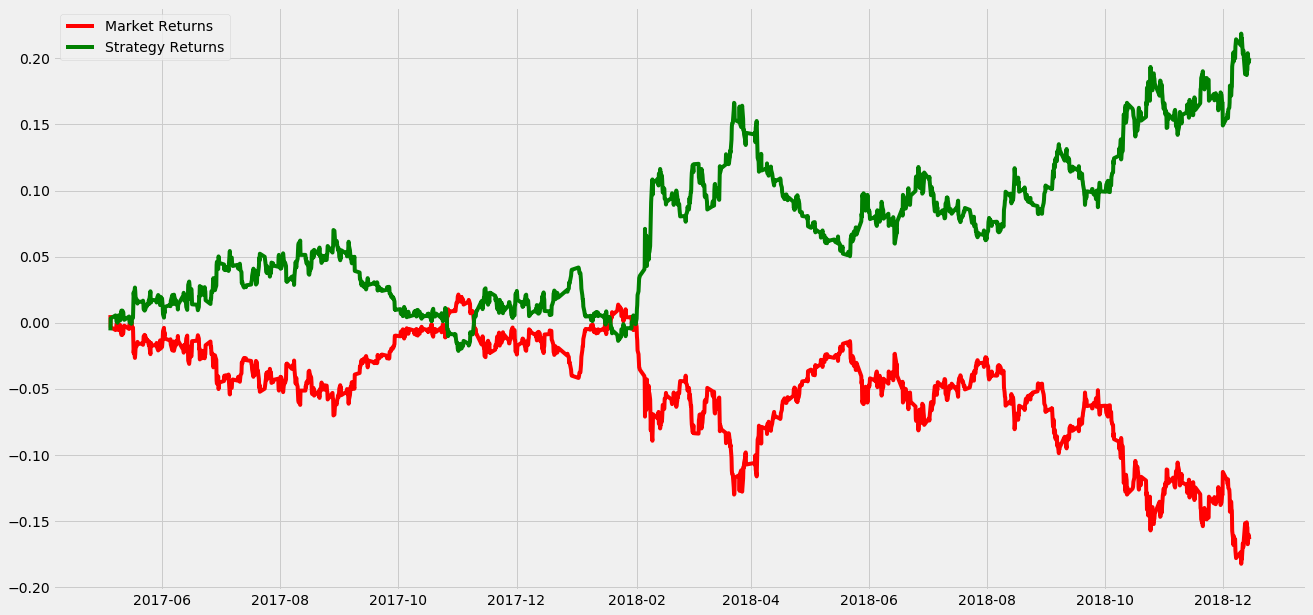

In [57]:
plt.figure(figsize=(20,10))
plt.plot(trade_dataset['cum_market_returns'], color='red', label='Market Returns')
plt.plot(trade_dataset['cum_strategy_returns'], color='green', label='Strategy Returns')
plt.legend()
plt.show()